# Propaganda Detection
This project explores the use of transformer-based models like BERT and RoBERTa to detect propaganda in text by distinguishing between propagandist and non-propagandist content.

## Environment Setup

In [1]:
# Set up for BERT and RoBERTA models
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel

# Additional utilities
import pandas as pd
from tqdm import tqdm
import numpy as np
import random
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Sets seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 27
set_seed(SEED)

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Loading and Exploration

In [3]:
# Loading training data and removing duplicate rows
train_df = pd.read_csv('./dataset/train.tsv', sep='\t').drop_duplicates()
train_df

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"
...,...,...
2409,not_propaganda,<BOS> We support and appreciate <EOS> your bus...
2410,not_propaganda,International Atomic Energy Agency (IAEA) Dire...
2411,not_propaganda,What has been done: there has been work on for...
2412,not_propaganda,This is <BOS> the law of gradualness not the g...


In [4]:
# Loading testing data and removing duplicate rows
test_df = pd.read_csv('./dataset/test.tsv', sep='\t').drop_duplicates()
test_df

,label,tagged_in_context
0,not_propaganda,"On average, between 300 and 600 infections are..."
1,causal_oversimplification,Mostly because <BOS> the country would not las...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.
4,repetition,It must be exacted from him directly in order ...
...,...,...
575,not_propaganda,"NewsCatholic Church, <BOS> Family, Marriage <E..."
576,not_propaganda,"Remember our saying, modern day fairy <BOS> ta..."
577,not_propaganda,Why <BOS> not <EOS> open up to Iran with massi...
578,flag_waving,<BOS> He also sang an Islamic State fight song...


In [5]:
# Check for missing (NaN) values in both training and testing DataFrames
train_df.isna().sum(),test_df.isna().sum()

(label                0
 tagged_in_context    0
 dtype: int64,
 label                0
 tagged_in_context    0
 dtype: int64)

In [6]:
# Display the unique labels in the 'label' column of the training DataFrame
train_df.label.unique()

array(['not_propaganda', 'flag_waving', 'loaded_language', 'doubt',
       'name_calling,labeling', 'appeal_to_fear_prejudice', 'repetition',
       'causal_oversimplification', 'exaggeration,minimisation'],
      dtype=object)

In [7]:
# Binary label encoding: mark all labels except 'not_propaganda' as 1, else 0
train_df['binary_label'] = (train_df['label'] != 'not_propaganda').astype(int)
test_df['binary_label'] = (test_df['label'] != 'not_propaganda').astype(int)

In [8]:
train_df.head(5)

,label,tagged_in_context,binary_label
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed.",0
1,not_propaganda,This declassification effort <BOS> won’t make ...,0
2,flag_waving,The Obama administration misled the <BOS> Amer...,1
3,not_propaganda,“It looks like we’re capturing the demise of t...,0
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>",0


In [9]:
test_df.head(5)

,label,tagged_in_context,binary_label
0,not_propaganda,"On average, between 300 and 600 infections are...",0
1,causal_oversimplification,Mostly because <BOS> the country would not las...,1
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....,1
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.,0
4,repetition,It must be exacted from him directly in order ...,1


### Distribution plot for training data

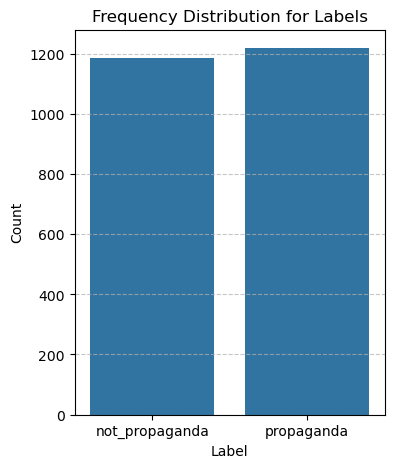

In [10]:
# Plot binary label distribution
plt.figure(figsize=(4,5))
sns.countplot(x='binary_label', data=train_df)

plt.xticks([0, 1], ['not_propaganda', 'propaganda'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Frequency Distribution for Labels')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Preprocessing

In [11]:
# Custom Dataset class
class PropagandaDataset(Dataset):
    def __init__(self, df, tokenizer, text_column='tagged_in_context'):
        self.labels = df['binary_label'].tolist()
        self.texts = [tokenizer(text, padding='max_length', max_length=256, truncation=True, return_tensors="pt") for text in df[text_column]]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Prepare inputs
def prepare_inputs(batch_input, labels, device):
    input_ids = batch_input['input_ids'].squeeze(1).to(device)
    attention_mask = batch_input['attention_mask'].squeeze(1).to(device)
    labels = labels.to(device).float()
    return input_ids, attention_mask, labels

## Modeling Utilities

In [12]:
# Training function
def train(model, train_data, learning_rate, epochs, batch_size):
    # Create a generator for reproducible shuffling
    g = torch.Generator()
    g.manual_seed(SEED)
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=g)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss, total_acc = 0, 0
        for batch_input, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            input_id, mask, labels = prepare_inputs(batch_input, labels, device)
            optimizer.zero_grad()
            outputs = model(input_id, mask).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            total_acc += (preds == labels).sum().item()

        print(f"Epoch {epoch+1}: Train Loss: {total_loss/len(train_loader):.4f}, Accuracy: {total_acc/len(train_data):.4f}")

    return model


# Evaluation function
def evaluate(model, test_data, batch_size):
    test_loader = DataLoader(test_data, batch_size=batch_size)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch_input, labels in tqdm(test_loader):
            input_id, mask, labels = prepare_inputs(batch_input, labels, device)
            outputs = model(input_id, mask).squeeze()
            preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    # Classification report and confusion matrix
    print("Classification Report\n")
    print(classification_report(all_labels, all_preds, target_names=["Not Propaganda", "Propaganda"]))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Propaganda", "Propaganda"], yticklabels=["Not Propaganda", "Propaganda"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

## BERT Model: Training and Evaluation

Training Epoch 1: 100%|██████████████████████████████████████████████████████████████| 151/151 [01:04<00:00,  2.34it/s]


Epoch 1: Train Loss: 0.4624, Accuracy: 0.7755


Training Epoch 2: 100%|██████████████████████████████████████████████████████████████| 151/151 [01:06<00:00,  2.26it/s]


Epoch 2: Train Loss: 0.1694, Accuracy: 0.9380


Training Epoch 3: 100%|██████████████████████████████████████████████████████████████| 151/151 [01:07<00:00,  2.23it/s]


Epoch 3: Train Loss: 0.0512, Accuracy: 0.9854


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  6.73it/s]

Classification Report

                precision    recall  f1-score   support

Not Propaganda       0.96      0.93      0.95       301
    Propaganda       0.93      0.96      0.95       279

      accuracy                           0.95       580
     macro avg       0.95      0.95      0.95       580
  weighted avg       0.95      0.95      0.95       580



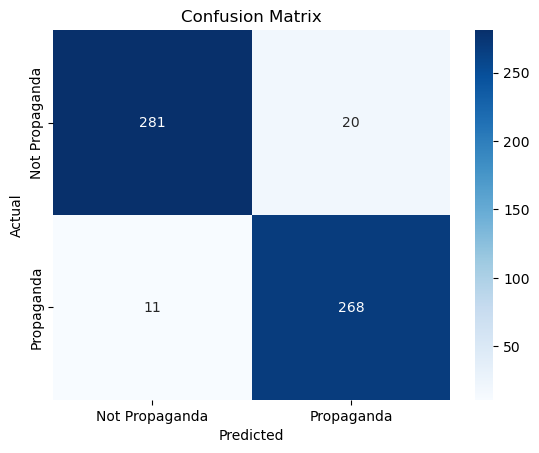

In [13]:
# Load tokenizer
bertTokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# BERT Model class
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super(BertBinaryClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        output = self.dropout(pooled_output)
        return self.linear(output)

# Convert preprocessed DataFrames to PropagandaDataset objects for BERT
bert_train_dataset = PropagandaDataset(train_df,bertTokenizer)
bert_test_dataset = PropagandaDataset(test_df,bertTokenizer)

# Hyperparameters
EPOCHS = 3
LEARNING_RATE = 2e-5
BATCH_SIZE = 16

# Initialize BERT Model
BertModel = BertBinaryClassifier()

# Train the model
BertModel = train(BertModel, bert_train_dataset, learning_rate=LEARNING_RATE, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Evaluate trained model on test dataset
evaluate(BertModel, bert_test_dataset, batch_size=BATCH_SIZE)

## RoBERTa Model: Training and Evaluation

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1: 100%|██████████████████████████████████████████████████████████████| 151/151 [01:08<00:00,  2.21it/s]


Epoch 1: Train Loss: 0.4283, Accuracy: 0.7854


Training Epoch 2: 100%|██████████████████████████████████████████████████████████████| 151/151 [01:09<00:00,  2.18it/s]


Epoch 2: Train Loss: 0.1921, Accuracy: 0.9264


Training Epoch 3: 100%|██████████████████████████████████████████████████████████████| 151/151 [01:09<00:00,  2.17it/s]


Epoch 3: Train Loss: 0.1030, Accuracy: 0.9701


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  6.57it/s]

Classification Report

                precision    recall  f1-score   support

Not Propaganda       0.94      0.95      0.95       301
    Propaganda       0.95      0.94      0.94       279

      accuracy                           0.94       580
     macro avg       0.94      0.94      0.94       580
  weighted avg       0.94      0.94      0.94       580



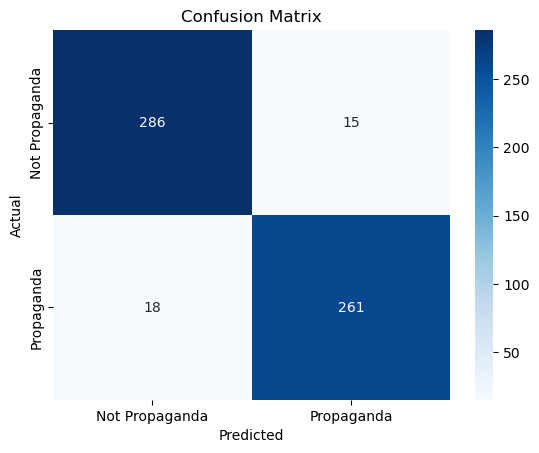

In [14]:
# Load tokenizer
robertaTokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# RoBERTa Model class
class RoBERTaClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super(RoBERTaClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)

    def forward(self, input_id, mask):
        _, pooled_output = self.roberta(input_ids=input_id, attention_mask=mask, return_dict=False)
        output = self.dropout(pooled_output)
        return self.linear(output)

# Convert preprocessed DataFrames to PropagandaDataset objects for BERT
roberta_train_dataset = PropagandaDataset(train_df,robertaTokenizer)
roberta_test_dataset = PropagandaDataset(test_df,robertaTokenizer)

# Hyperparameters
EPOCHS = 3
LEARNING_RATE = 2e-5
BATCH_SIZE = 16

# Initialize RoBERTa Model
RoBERTaModel = RoBERTaClassifier()

# Train the model
RoBERTaModel = train(RoBERTaModel, roberta_train_dataset, learning_rate=LEARNING_RATE, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Evaluate trained model on test dataset
evaluate(RoBERTaModel, roberta_test_dataset, batch_size=BATCH_SIZE)

## Conclusion
In this binary classification task for propaganda detection:

* **BERT** achieved an **accuracy of 95%**, with slightly better performance on **Propaganda** detection (F1: 0.95).
* **RoBERTa** achieved a comparable **accuracy of 94%**, performing marginally better on **Not Propaganda** detection.

| Model   | Accuracy | F1 (NP) | F1 (P) |
| ------- | -------- | ------- | ------ |
| BERT    | 0.95     | 0.95    | 0.95   |
| RoBERTa | 0.94     | 0.95    | 0.94   |

Both models perform well overall, with **BERT showing a slight edge in recall for propaganda** instances, while **RoBERTa makes fewer false positives on non-propaganda**.

#### Final Recommendation:

Opt for BERT when the priority is to detect as much propaganda as possible, and choose RoBERTa if avoiding false flags on non-propaganda content is more important.